In [198]:
"""
    Attempts to comprehend teams' rankings:
    1. Understanding final ranking in the league due to given situations
    2. Proof of clustering team's performance on promotions
"""

"\n    Attempts to comprehend teams' rankings:\n    1. Understanding final ranking in the league due to given situations\n    2. Proof of clustering team's performance on promotions\n"

In [2]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
class Attr:
    def __init__(self, name, value, color=None):
        self.name = name
        self.value = value
        self.color = color
    def __str__(self):
        return "name: " + self.name + " value: " + str(self.value)

In [4]:
def get_value(attr):
    return attr.value

In [5]:
def sorted_class(names, values, color=None):
    attrs = []
    for i in range(0, len(names)):
        attrs.append(Attr(names[i], values[i]))
    attrs.sort(key=get_value)
    new_names = []
    new_values = []
    for i in range(0, len(names)):
        new_names.append(attrs[i].name)
        new_values.append(attrs[i].value)
    return new_names, new_values

In [6]:
def encode_data(df, df_column):
    elements = np.unique(df[df_column].astype(str))
    print(len(elements))
    print(elements)
    enc = preprocessing.LabelEncoder()
    enc.fit(elements)
    return enc.transform(df[df_column].astype(str))

In [7]:
def encode_description(row):
    label = {'Promotion - Champions League (Group Stage)': 1, 
             'UEFA Champions League': 1,
             'UEFA Champions League Qualifiers': 2,
            'Promotion - Europa League (Group Stage)': 3,
             'UEFA Europa League': 3,
             'Promotion - Europa League (Qualification)': 4,
             'nan': 5,
             'Relegation - LaLiga2': 6,
             'Relegation': 6
            }
    if row in label:
        return label[row]
    else:
        return 5

In [8]:
def score_home(best):
    if best != 0:
        return int(best[0]) - int(best[2])
    return best

In [9]:
def score_away(best):
    if best != 0:
        return int(best[2]) - int(best[0])
    return best

In [10]:
def clean_data(df, clean_type=None):
    df = df.drop(df.columns[0], axis=1)
    # Ratio of games lose/played, draws/played
    #df["stats_away.lose"] = df["stats_away.lose"]/df["stats_away.played"]
    #df["stats_away.draws"] = df["stats_away.draws"]/df["stats_away.played"]
    #df["stats_home.lose"] = df["stats_home.lose"]/df["stats_home.played"]
    #df["stats_home.draws"] = df["stats_home.draws"]/df["stats_home.played"]
    df = df.drop(columns=["team.id", "team.name","season","league","goals_diff","form","group","stats_home.played","stats_away.played",
                          "stats_home.wins", "stats_away.wins", "stats_home.goals_for", "stats_home.goals_against",
                         "stats_away.goals_for", "stats_away.goals_against"], axis=1)
    # Encode description (Promotion: either Champions, UEFA Europe, Second division)
    df["description"] = df["description"].apply(encode_description)
    # None values set to 0
    df.fillna(value=0, inplace=True)
    if clean_type == 'home':
        # Delete stats from away matches
        df = df.drop(df.filter(regex='stats_away').columns, axis=1)
        # For best_lose
        df["stats_home.streaks.best_lose"] = df["stats_home.streaks.best_lose"].apply(score_home)
        # For best_win
        df["stats_home.streaks.best_win"] = df["stats_home.streaks.best_win"].apply(score_home)
    elif clean_type == 'away':
        # Delete stats from away matches
        df = df.drop(df.filter(regex='stats_home').columns, axis=1)
        # For best_lose
        df["stats_away.streaks.best_lose"] = df["stats_away.streaks.best_lose"].apply(score_home)
        # For best_win
        df["stats_away.streaks.best_win"] = df["stats_away.streaks.best_win"].apply(score_home)
    else:
        # For best_lose
        df["stats_home.streaks.best_lose"] = df["stats_home.streaks.best_lose"].apply(score_home)
        df["stats_away.streaks.best_lose"] = df["stats_away.streaks.best_lose"].apply(score_away)
        # For best_win
        df["stats_home.streaks.best_win"] = df["stats_home.streaks.best_win"].apply(score_home)
        df["stats_away.streaks.best_win"] = df["stats_away.streaks.best_win"].apply(score_away)
    return df

In [11]:
def get_target(df, label):
    target = []
    for index, row in df.iterrows():
        target.append(row[label])
    return target

In [21]:
# Label is the set of columns to keep as target
def df_season(country, league, season, label, drop_others=None, clean_type=None):
    dirCountry = '../' + country + '/'
    dirName = dirCountry + league + '/' + str(season) + '/'
    file_title = str(season) + '.csv'
    csv_file = dirName + file_title
    df = pd.read_csv(csv_file)
    df_names = df['team.name'].tolist()
    #df_names = df['team.name'].tolist()
    df = clean_data(df, clean_type)
    target = []
    for l in label:
        target = target + [get_target(df, l)]
    df = df.drop(columns=label, axis=1)
    if drop_others != None:
        df = df.drop(columns=drop_others, axis=1)
    return df, target, df_names

In [13]:
def get_all_data(data, target_n):
    all_data = pd.DataFrame()
    all_season = []
    all_names = []
    all_target = [ [] for _ in range(target_n) ]
    for d in data:
        all_data = all_data.append(d[1])
        all_season = all_season + [d[0] for _ in range(len(d[1]))]
        all_names = all_names + d[3]
        i = 0
        for target in d[2]:
            all_target[i] = all_target[i] + target
            i = i + 1
    return all_data, all_season, all_names, all_target

In [14]:
def weights_graph(axs, row, season, model, val, rmse, r_sq, weights, x_label):
    title = str(season) + ' ' + model + ' ' + val
    rmse_txt = "RMSE: " + '{0:.2f}'.format(rmse)
    r_txt = "R^2: " + '{0:.2f}'.format(r_sq)
    x_label, weights = sorted_class(x_label, weights)
    axs[row].bar(x_label, weights)
    axs[row].set_title(title)
    axs[row].text(1, 1.1, rmse_txt, color="b", fontsize=10, horizontalalignment='center', verticalalignment='center',
     transform = axs[row].transAxes)
    axs[row].text(1, 1.2, r_txt, color="b", fontsize=10, horizontalalignment='center', verticalalignment='center',
     transform = axs[row].transAxes)
    axs[row].tick_params(axis='x', labelrotation=90)
    for i in range(len(x_label)):
        axs[row].annotate('{0:.2f}'.format(weights[i]), xy=(x_label[i], weights[i]), verticalalignment='bottom')
    return axs

In [15]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
def ols_ridge(season, data, target, test_len=None, cross_val=None):
    r = 2
    fig, axs = plt.subplots(r)
    fig.set_size_inches(18.5, 10.5)
    # Create index mat
    mat = [j for j in range(0, r)]
    i = 0
    
    x_label = data.columns
    scaler = preprocessing.StandardScaler()
    data = scaler.fit_transform(data)
    if test_len != None:
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=test_len, random_state=0)
    classifiers = dict(ols=linear_model.LinearRegression(), ridge=linear_model.Ridge(alpha=.1))
    
    for name, clf in classifiers.items():
        if cross_val != None:
            clf_mse = cross_validate(clf, data, target, cv=cross_val, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True, return_estimator=True)
            mse_sqr = np.sqrt(clf_mse['test_neg_mean_squared_error'].mean()*-1)
            mse_r = np.sqrt(clf_mse['test_r2'].mean())
            coef = []
            for model in clf_mse['estimator']:
                coef.append(model.coef_)
            final_coef = np.matrix(coef)
            final_coef = final_coef.mean(0)
            final_coef = np.array(final_coef).flatten()
            axs = weights_graph(axs, mat[i], season, name, "cv-5", mse_sqr, mse_r, final_coef, x_label)
        else:
            clf.fit(X_train, y_train)
            Y = clf.predict(X_test)
            mse = mean_squared_error(y_test, Y)
            axs = weights_graph(axs, mat[i], season, name, "train-test", np.sqrt(mse), clf.score(X_test, y_test), clf.coef_, x_label)
        i = i + 1
    
    fig.tight_layout()
    plt.show()

In [16]:
# League directory
country = 'ES'
league = '140'
curr_week = 38

In [17]:
# Historicity: multi season directory
year_window = 4
start_season = 2019
seasons = list(range(start_season, start_season - year_window, -1))
print(seasons)

[2019, 2018, 2017, 2016]


In [22]:
# Data initialization
data = []
# Targets
target_col = ["rank", "points", "description"]
for season in seasons:
    df, target, name = df_season(country, league, season, target_col, clean_type='none')
    tup = (season, df, target, name)
    data.append(tup)

In [23]:
"""
    Index for plot
"""
i_th = data[0][1].columns.get_loc("stats_home.avg_goals_for")
i_ta = data[0][1].columns.get_loc("stats_away.avg_goals_against")

In [265]:
"""
    Here we have a dataset with the 4 years together
"""
all_data, all_season, all_names, all_target = get_all_data(data, len(target_col))

In [266]:
all_data.head()

,stats_home.draws,stats_home.lose,stats_home.avg_goals_for,stats_home.avg_goals_against,stats_home.clean_sheet,stats_home.failed_to_score,stats_home.streaks.wins,stats_home.streaks.draws,stats_home.streaks.loses,stats_home.streaks.best_win,...,stats_away.avg_goals_against,stats_away.clean_sheet,stats_away.failed_to_score,stats_away.streaks.wins,stats_away.streaks.draws,stats_away.streaks.loses,stats_away.streaks.best_win,stats_away.streaks.best_lose,stats_away.streaks.best_goals_for,stats_away.streaks.best_goals_against
0,5,5,1.9,1.3,7,2,3,1,3,4,...,1.3,5,1,3,1,3,3,3,3,3
1,3,8,1.3,1.2,5,7,2,1,3,4,...,2.3,0,11,2,1,3,1,1,3,5
2,7,1,1.5,0.8,7,1,2,2,3,2,...,1.9,1,8,2,2,3,2,2,4,5
3,4,6,1.8,1.4,3,1,3,2,2,3,...,1.7,3,9,3,2,2,1,1,2,5
4,3,6,1.4,0.8,8,3,3,2,3,4,...,1.5,5,7,3,2,3,3,3,4,4


In [267]:
print(all_data.shape)

(80, 26)


In [268]:
# Target 0 : rank
# Target 1 : points
# Target 2: description
print(len(all_target[0]))

80


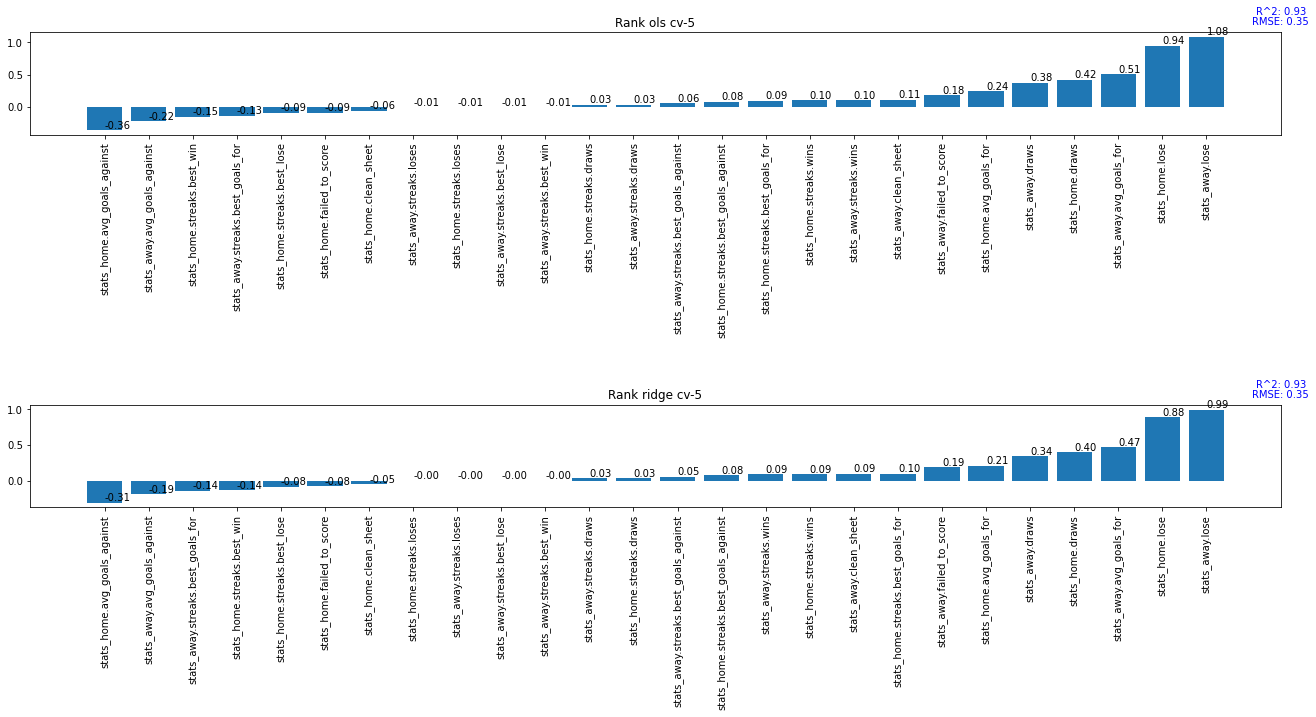

In [269]:
"""
    Rank fit
"""
# Before scalate the target
new_target = preprocessing.scale(all_target[0])
ols_ridge("Rank", all_data, new_target, cross_val = 5)

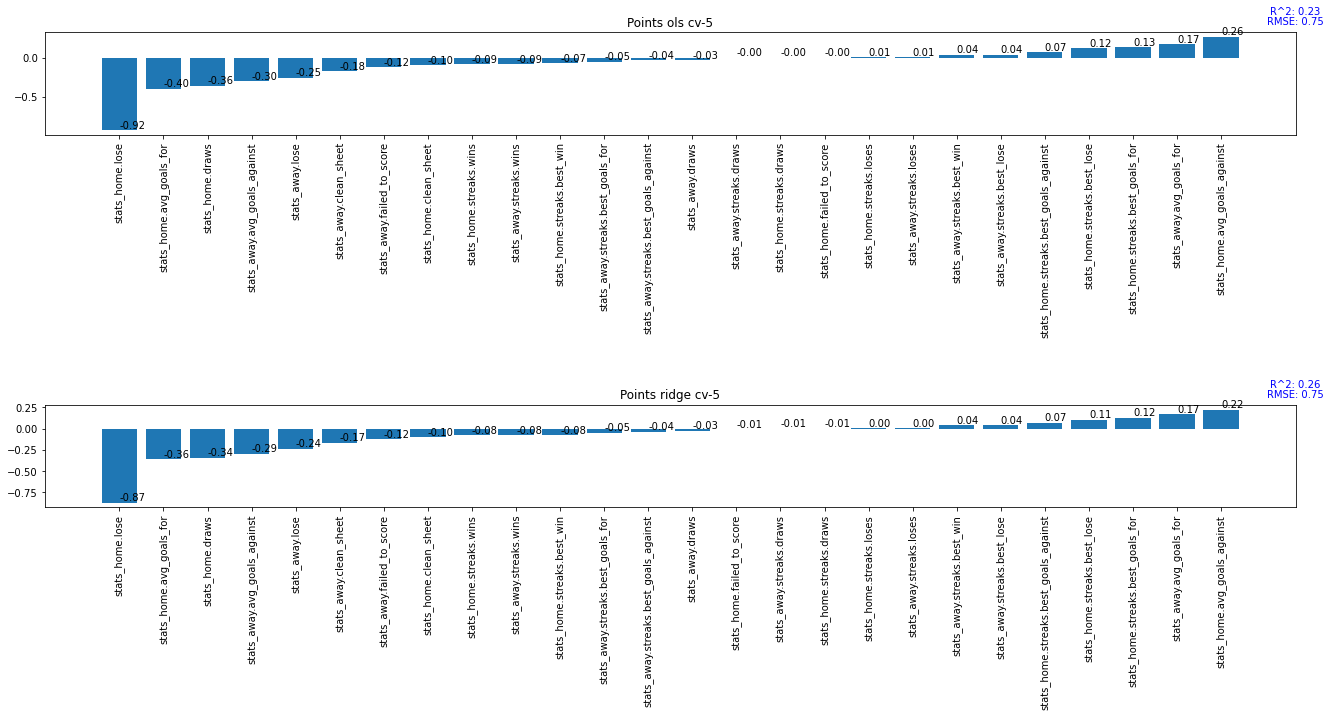

In [270]:
"""
    Points fit
"""
new_target = preprocessing.scale(all_target[1])
ols_ridge("Points", all_data, new_target, cross_val = 5)

In [271]:
def scatter_graph(cluster, data, season, names, x, y):
    plt.scatter(data[:, i_th], data[:, i_ta], c=cluster, s=80, cmap='viridis')

In [272]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
def Kmeans(data):
    bestSilhouette_score = -1
    bestK = 0
    for i in list(range(2,6)):
        cluster = KMeans(n_clusters=i).fit_predict(data)
        cluster = pd.Series(cluster)
        silhouette = silhouette_score(data, cluster)
        print("k: %s s_score: %s" % (i , silhouette))
        if silhouette > bestSilhouette_score:
            bestK = i
            bestSilhouette_score = silhouette
    cluster = KMeans(n_clusters=5).fit_predict(data)
    return cluster

In [273]:
def dendogram_graph(data, best_method, label):
    Z = linkage(data, best_method)
    fig = plt.figure(figsize=(25, 10))
    dendo = dendrogram(Z, leaf_rotation=90, labels=label)
    plt.title(best_method)
    plt.show()
    return Z

In [274]:
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram
from scipy.spatial.distance import pdist
def HierarchichalClustering(data, label):
    methods = ["single","complete","average","centroid","ward"]

    # Pass the dataset into pdist to get your proximity matrix for calculating CPCC
    proximity_matrix = pdist(data)

    best_coph = -1
    best_method = None

    for method in methods:
        Z = linkage(data, method)
        coph, coph_matrix = cophenet(Z, proximity_matrix)
        if coph > best_coph:
            best_coph = coph
            best_method = method
    return dendogram_graph(data, best_method, label), best_coph

k: 2 s_score: 0.27138882753238175
k: 3 s_score: 0.16284930208646156
k: 4 s_score: 0.1637721656777853
k: 5 s_score: 0.15270661532074395


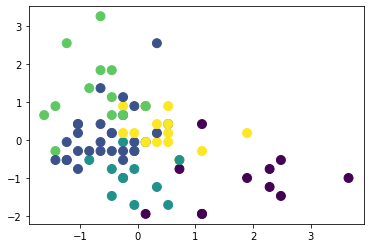

In [275]:
"""
    Clustering the description
    1: Kmeans: tunning from 3 to 6 k
    2. Agglomerative hierarchical clustering
"""
all_data = preprocessing.StandardScaler().fit_transform(all_data)
cluster = Kmeans(all_data)
# Values closer to cero indicate overlapping clusters
scatter_graph(cluster, all_data, all_season, all_names, i_th, i_ta)

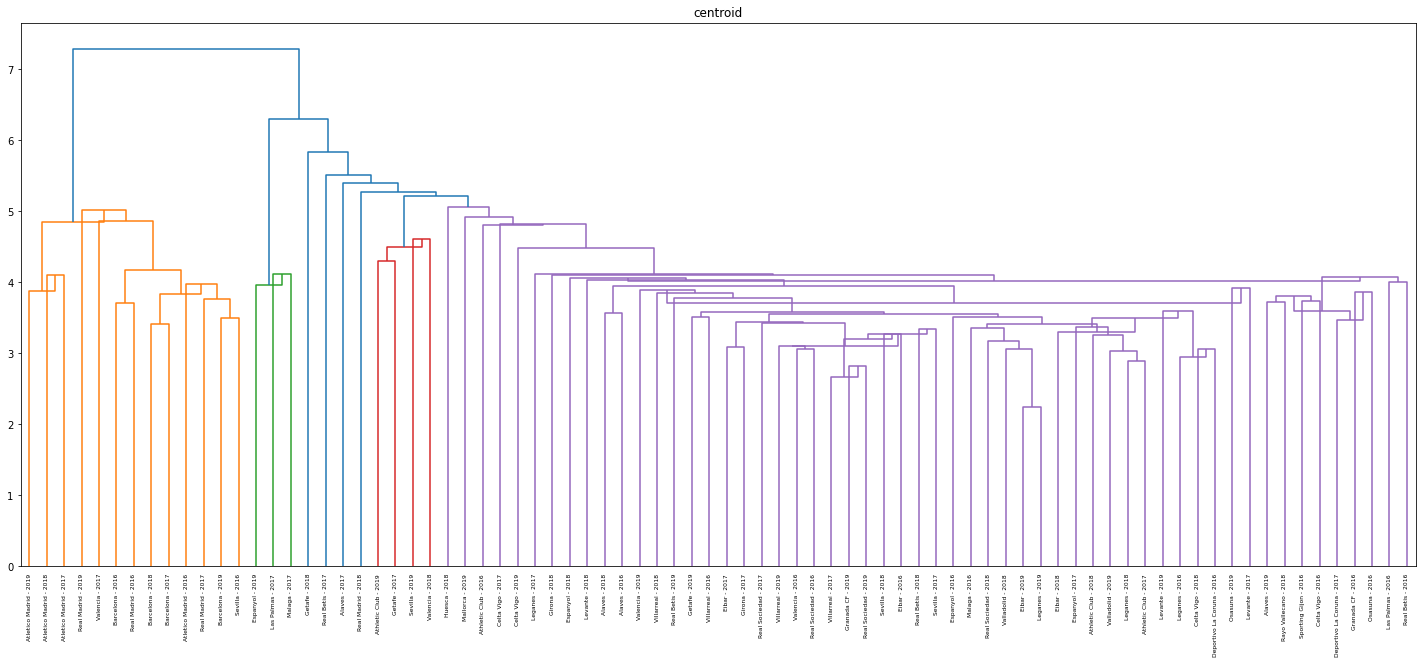

In [276]:
# Use Agglomerative
dendo_label = []
for i in range(len(all_season)):
    d_l = all_names[i] + " - " + str(all_season[i])
    dendo_label.append(d_l)
Z, coph = HierarchichalClustering(all_data, dendo_label)

In [277]:
from scipy.cluster.hierarchy import fcluster

clusters = fcluster(Z, t=5.2, criterion='distance')

In [278]:
print(clusters)

[4 4 4 4 4 1 4 4 4 1 4 4 3 3 2 1 4 4 4 4 4 3 4 1 4 4 4 1 4 4 4 4 4 4 4 4 5
 8 4 4 4 2 2 1 7 4 1 4 6 4 1 4 4 4 4 4 4 1 3 4 4 4 4 4 4 4 4 4 1 4 4 4 1 4
 4 1 4 1 4 4]


In [279]:
h_clusters = []
for i in range(0, len(dendo_label)):
    h_clusters.append(Attr(dendo_label[i], clusters[i]))
h_clusters.sort(key=get_value)
for c in h_clusters:
    print(c)

name: Barcelona - 2019 value: 1
name: Atletico Madrid - 2019 value: 1
name: Real Madrid - 2019 value: 1
name: Barcelona - 2018 value: 1
name: Atletico Madrid - 2018 value: 1
name: Valencia - 2017 value: 1
name: Barcelona - 2017 value: 1
name: Atletico Madrid - 2017 value: 1
name: Real Madrid - 2017 value: 1
name: Barcelona - 2016 value: 1
name: Atletico Madrid - 2016 value: 1
name: Sevilla - 2016 value: 1
name: Real Madrid - 2016 value: 1
name: Espanyol - 2019 value: 2
name: Las Palmas - 2017 value: 2
name: Malaga - 2017 value: 2
name: Athletic Club - 2019 value: 3
name: Sevilla - 2019 value: 3
name: Valencia - 2018 value: 3
name: Getafe - 2017 value: 3
name: Villarreal - 2019 value: 4
name: Mallorca - 2019 value: 4
name: Valencia - 2019 value: 4
name: Real Betis - 2019 value: 4
name: Granada CF - 2019 value: 4
name: Eibar - 2019 value: 4
name: Alaves - 2019 value: 4
name: Leganes - 2019 value: 4
name: Levante - 2019 value: 4
name: Celta Vigo - 2019 value: 4
name: Getafe - 2019 value: 

In [280]:
"""
    Ranking home
"""

'\n    Ranking home\n'

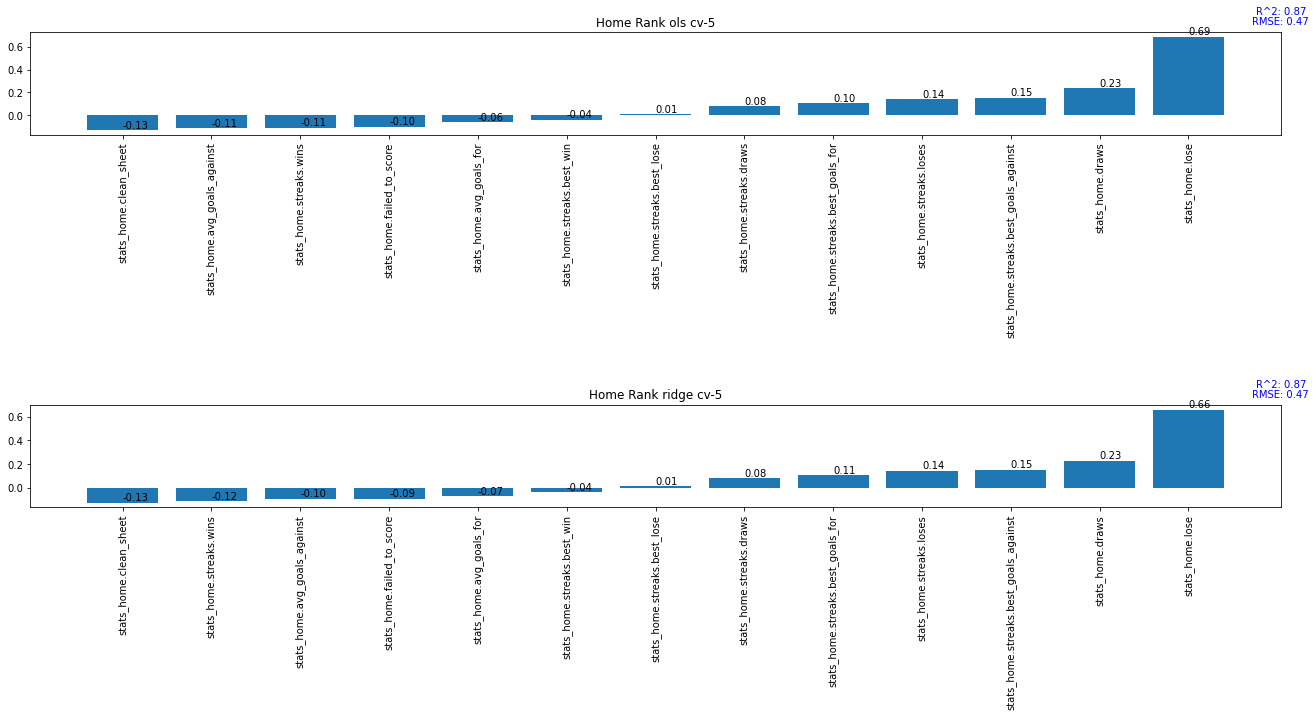

In [281]:
# Data initialization
home_data = []
# Targets
target_col = ["rank", "points", "description"]
for season in seasons:
    df, target, name = df_season(country, league, season, target_col, clean_type='home')
    tup = (season, df, target, name)
    home_data.append(tup)
all_data, all_season, all_names, all_target = get_all_data(home_data, len(target_col))
# Before scalate the target
new_target = preprocessing.scale(all_target[0])
ols_ridge("Home Rank", all_data, new_target, cross_val = 5)

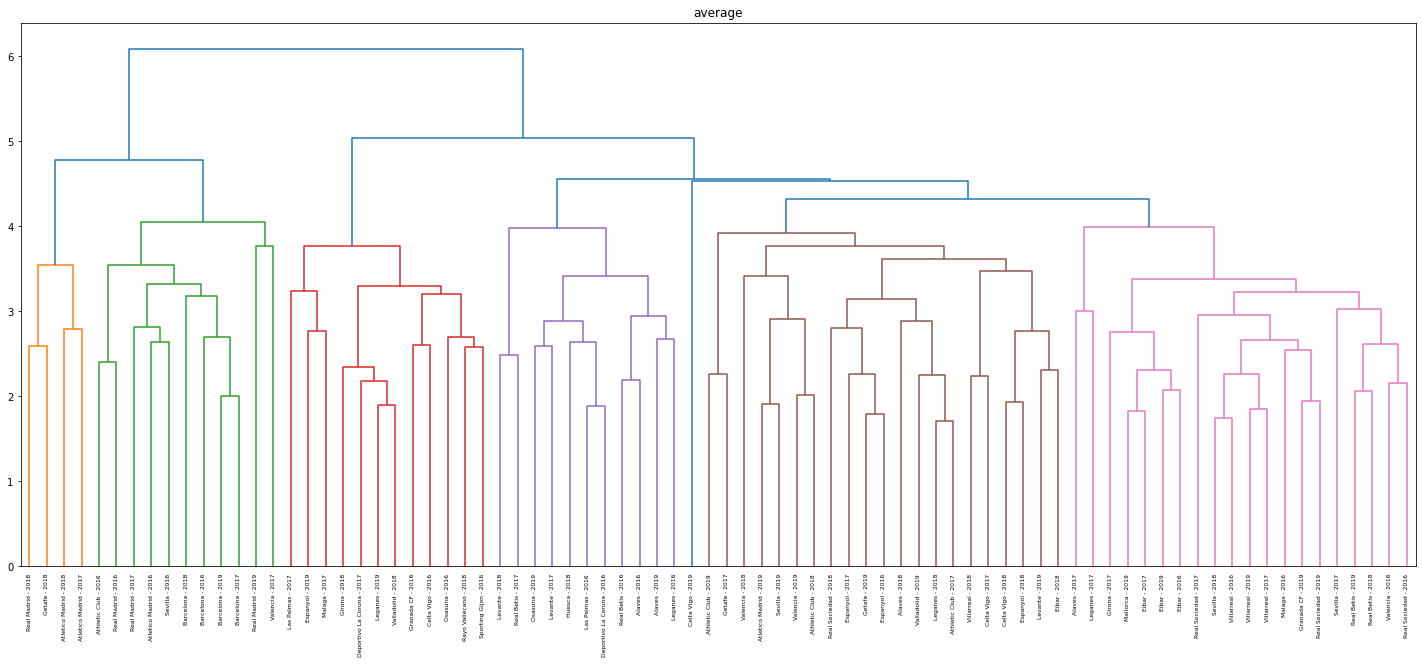

In [282]:
# Use Agglomerative
all_data = preprocessing.StandardScaler().fit_transform(all_data)
dendo_label = []
for i in range(len(all_season)):
    d_l = all_names[i] + " - " + str(all_season[i])
    dendo_label.append(d_l)
Z, coph = HierarchichalClustering(all_data, dendo_label)

In [283]:
clusters = fcluster(Z, t=4.5, criterion='distance')
print(clusters)
h_clusters = []
for i in range(0, len(dendo_label)):
    h_clusters.append(Attr(dendo_label[i], clusters[i]))
h_clusters.sort(key=get_value)
for c in h_clusters:
    print(c)

[5 5 5 5 5 2 5 4 3 5 5 6 5 5 3 2 5 5 5 4 5 5 5 2 5 5 5 1 4 5 5 5 3 5 4 3 1
 1 5 3 5 3 3 2 4 3 2 5 5 5 1 4 5 5 5 5 5 2 5 5 5 4 3 5 5 4 4 3 2 5 4 4 2 3
 2 2 5 2 5 3]
name: Atletico Madrid - 2018 value: 1
name: Real Madrid - 2018 value: 1
name: Getafe - 2018 value: 1
name: Atletico Madrid - 2017 value: 1
name: Barcelona - 2019 value: 2
name: Real Madrid - 2019 value: 2
name: Barcelona - 2018 value: 2
name: Valencia - 2017 value: 2
name: Barcelona - 2017 value: 2
name: Real Madrid - 2017 value: 2
name: Barcelona - 2016 value: 2
name: Atletico Madrid - 2016 value: 2
name: Athletic Club - 2016 value: 2
name: Sevilla - 2016 value: 2
name: Real Madrid - 2016 value: 2
name: Leganes - 2019 value: 3
name: Espanyol - 2019 value: 3
name: Girona - 2018 value: 3
name: Rayo Vallecano - 2018 value: 3
name: Valladolid - 2018 value: 3
name: Las Palmas - 2017 value: 3
name: Malaga - 2017 value: 3
name: Deportivo La Coruna - 2017 value: 3
name: Sporting Gijon - 2016 value: 3
name: Granada CF - 2016 value: 

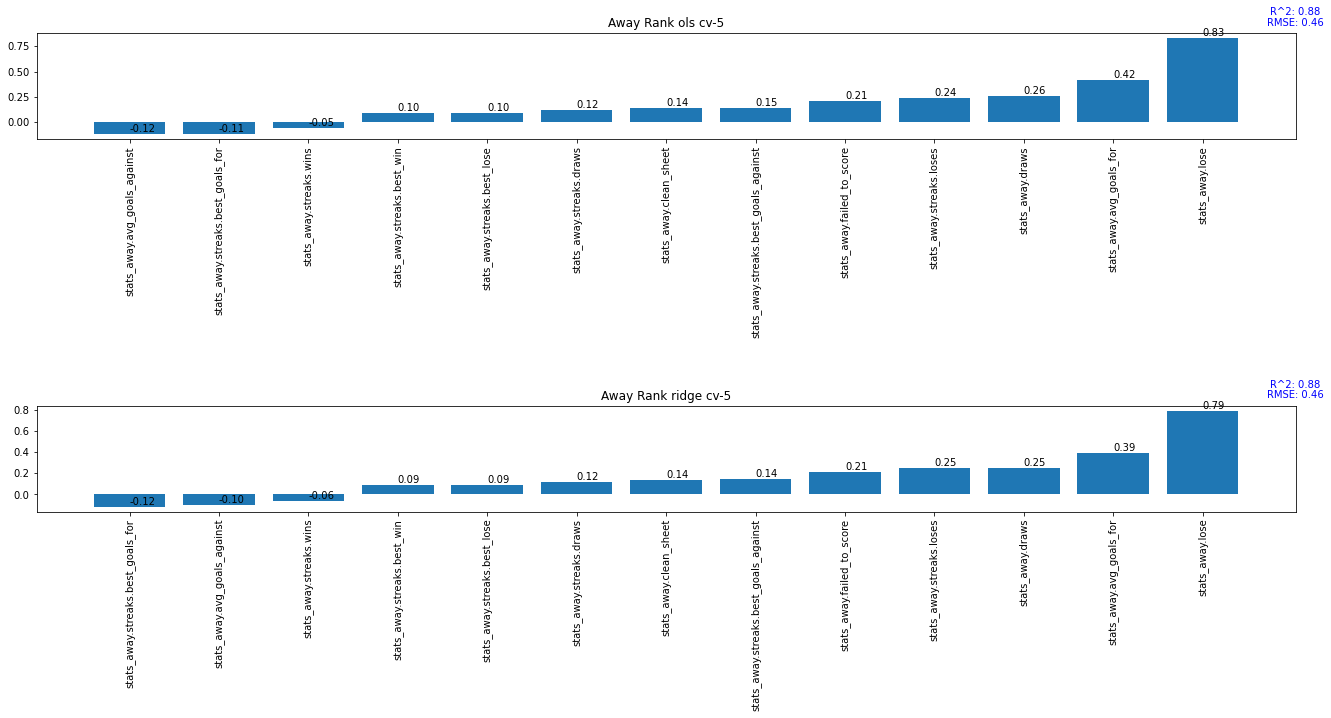

In [284]:
"""
    Ranking away
"""
away_data = []
# Targets
target_col = ["rank", "points", "description"]
for season in seasons:
    df, target, name = df_season(country, league, season, target_col, clean_type='away')
    tup = (season, df, target, name)
    away_data.append(tup)
all_data, all_season, all_names, all_target = get_all_data(away_data, len(target_col))
# Before scalate the target
new_target = preprocessing.scale(all_target[0])
ols_ridge("Away Rank", all_data, new_target, cross_val = 5)

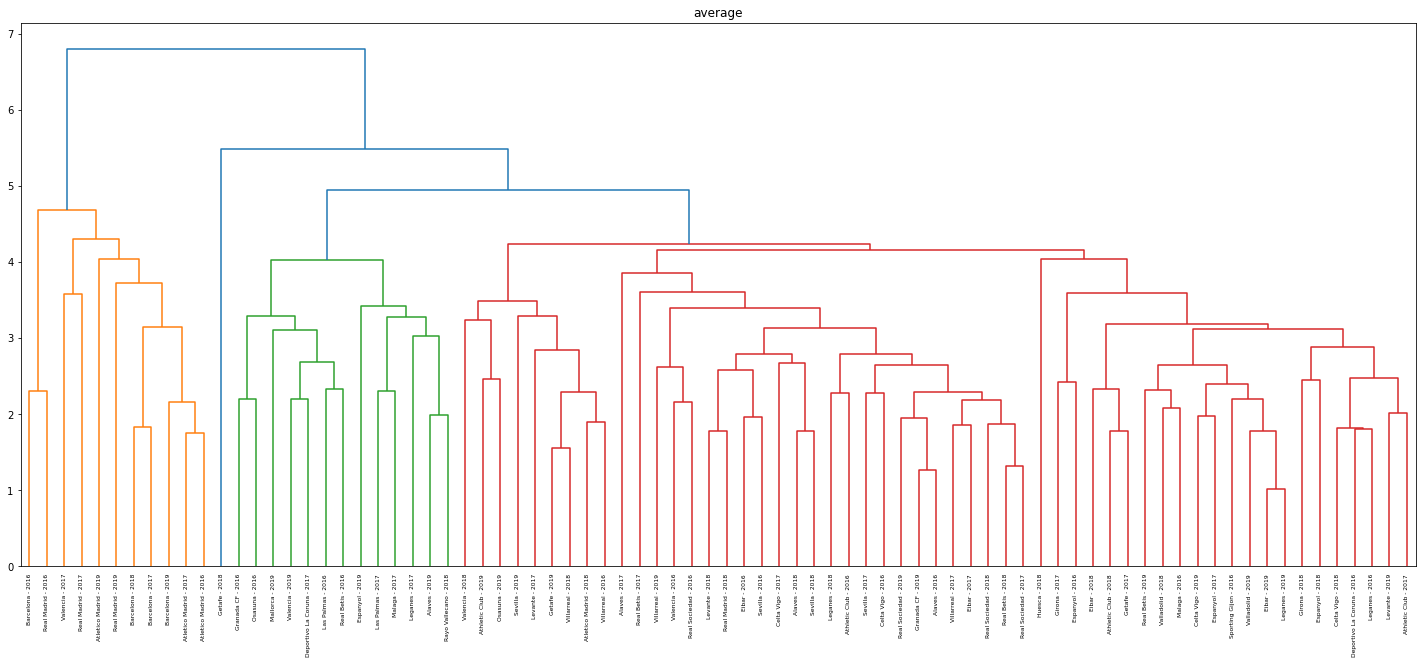

In [285]:
# Use Agglomerative
all_data = preprocessing.StandardScaler().fit_transform(all_data)
dendo_label = []
for i in range(len(all_season)):
    d_l = all_names[i] + " - " + str(all_season[i])
    dendo_label.append(d_l)
Z, coph = HierarchichalClustering(all_data, dendo_label)

In [286]:
clusters = fcluster(Z, t=4.7, criterion='distance')
print(clusters)
h_clusters = []
for i in range(0, len(dendo_label)):
    h_clusters.append(Attr(dendo_label[i], clusters[i]))
h_clusters.sort(key=get_value)
for c in h_clusters:
    print(c)

[3 2 2 3 3 1 3 2 3 1 3 3 3 3 2 1 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 2 3
 4 3 3 3 2 2 1 3 2 1 3 3 2 1 3 3 3 3 3 3 1 3 3 3 2 3 3 3 2 3 2 1 3 3 3 1 3
 3 3 3 1 3 2]
name: Barcelona - 2019 value: 1
name: Atletico Madrid - 2019 value: 1
name: Real Madrid - 2019 value: 1
name: Barcelona - 2018 value: 1
name: Valencia - 2017 value: 1
name: Barcelona - 2017 value: 1
name: Atletico Madrid - 2017 value: 1
name: Real Madrid - 2017 value: 1
name: Barcelona - 2016 value: 1
name: Atletico Madrid - 2016 value: 1
name: Real Madrid - 2016 value: 1
name: Mallorca - 2019 value: 2
name: Valencia - 2019 value: 2
name: Alaves - 2019 value: 2
name: Espanyol - 2019 value: 2
name: Rayo Vallecano - 2018 value: 2
name: Las Palmas - 2017 value: 2
name: Malaga - 2017 value: 2
name: Deportivo La Coruna - 2017 value: 2
name: Leganes - 2017 value: 2
name: Las Palmas - 2016 value: 2
name: Real Betis - 2016 value: 2
name: Granada CF - 2016 value: 2
name: Osasuna - 2016 value: 2
name: Villarreal - 2019 value: 3
name: 